=== Heart files for run: cow_runV23 ===
  C_pa.txt
  E_la.txt
  E_lv.txt
  E_rv.txt
  L_la.txt
  L_lv_aorta.txt
  L_ra.txt
  L_rv.txt
  R_la.txt
  R_lv_aorta.txt
  R_pa.txt
  R_ra.txt
  R_rv.txt
  V_ra.txt
  aorta.txt
  g.txt
  g1.txt
  g2.txt
  g3.txt
  p_LA1.txt
  p_LA2.txt
  p_LA3.txt
  p_LV1.txt
  p_RA1.txt
  p_RA2.txt
  p_RA3.txt
  p_RV1.txt
  p_RV2.txt

======= LEVEL-1 SANITY CHECK =======
Run: cow_runV23
Probe P: aorta.txt, Q: R_lv_aorta.txt

Systolic (mmHg):   116.94
Diastolic (mmHg):  1.09
Mean (mmHg):       88.31
Pulse (mmHg):      115.85
Heart Rate (bpm):  75.72
Cardiac Output (L/min): 4.73

--- Physiological Ranges ---
Systolic:       110–130 mmHg
Diastolic:      70–90 mmHg
MAP:            85–100 mmHg
Pulse Pressure: 35–55 mmHg
CO:             4.5–5.5 L/min
HR:             55–90 bpm


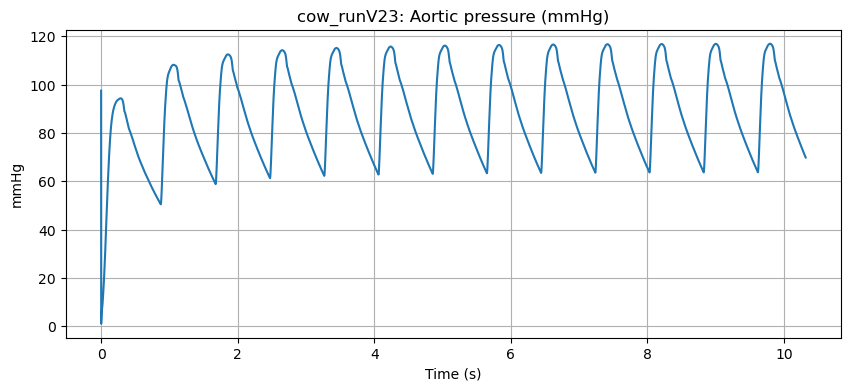

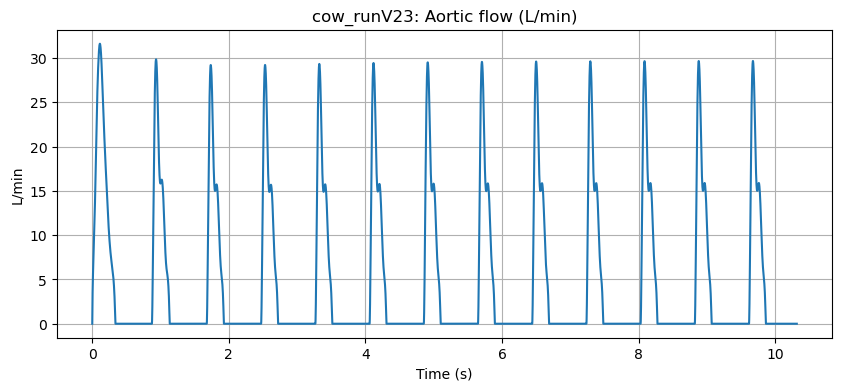

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def load_ts(path):
    """Robust loader for first_blood txt files (handles commas, etc.)."""
    with open(path, "r") as f:
        raw = f.readlines()

    data = []
    for line in raw:
        line = line.replace(",", " ").replace(";", " ").strip()
        if not line:
            continue
        parts = line.split()
        if len(parts) < 2:
            continue
        try:
            t = float(parts[0])
            v = float(parts[1])
            data.append([t, v])
        except ValueError:
            continue

    if not data:
        raise ValueError(f"No numeric rows in {path}")
    arr = np.array(data)
    return arr[:, 0], arr[:, 1]


def analyze_run(
    run_name,
    p_file="aorta.txt",
    q_file="R_lv_aorta.txt",
    use_ground_baseline=True,
):
    """
    Level-1 sanity analysis for a given simulation run.
    Works for Abel_ref2, cow_runV23, etc.

    - run_name: folder name under ../projects/simple_run/results/
    - p_file:   pressure probe file inside heart_kim_lit
    - q_file:   flow probe file (e.g. resistor to aorta) inside heart_kim_lit
    - use_ground_baseline: if True, subtract g.txt as atmospheric baseline
    """

    base_dir = f"../projects/simple_run/results/{run_name}"
    heart_dir = os.path.join(base_dir, "heart_kim_lit")

    # list available signals
    print(f"=== Heart files for run: {run_name} ===")
    for fname in sorted(os.listdir(heart_dir)):
        print(" ", fname)

    P_PATH = os.path.join(heart_dir, p_file)
    Q_PATH = os.path.join(heart_dir, q_file)
    G_PATH = os.path.join(heart_dir, "g.txt")

    t_p, p_raw = load_ts(P_PATH)
    t_q, q_raw = load_ts(Q_PATH)

    # gauge pressure: subtract ground if available, otherwise 1e5 Pa
    if use_ground_baseline and os.path.exists(G_PATH):
        _, g_raw = load_ts(G_PATH)
        p_gauge = p_raw - g_raw
    else:
        p_gauge = p_raw - 1.0e5  # fallback

    # unit conversion
    p_mmHg = p_gauge / 133.322  # Pa -> mmHg
    q_Lmin = q_raw * 60.0 * 1000.0  # m^3/s -> L/min

    # metrics
    P_sys = np.max(p_mmHg)
    P_dia = np.min(p_mmHg)
    P_mean = np.mean(p_mmHg)
    PP = P_sys - P_dia

    peaks, _ = find_peaks(p_mmHg, distance=40)
    if len(peaks) > 1:
        dt = np.diff(t_p[peaks]).mean()
        HR = 60.0 / dt
    else:
        HR = np.nan

    CO = np.mean(q_Lmin)

    print("\n======= LEVEL-1 SANITY CHECK =======")
    print(f"Run: {run_name}")
    print(f"Probe P: {p_file}, Q: {q_file}\n")
    print(f"Systolic (mmHg):   {P_sys:.2f}")
    print(f"Diastolic (mmHg):  {P_dia:.2f}")
    print(f"Mean (mmHg):       {P_mean:.2f}")
    print(f"Pulse (mmHg):      {PP:.2f}")
    print(f"Heart Rate (bpm):  {HR:.2f}")
    print(f"Cardiac Output (L/min): {CO:.2f}")

    print("\n--- Physiological Ranges ---")
    print("Systolic:       110–130 mmHg")
    print("Diastolic:      70–90 mmHg")
    print("MAP:            85–100 mmHg")
    print("Pulse Pressure: 35–55 mmHg")
    print("CO:             4.5–5.5 L/min")
    print("HR:             55–90 bpm")

    # plots
    plt.figure(figsize=(10, 4))
    plt.plot(t_p, p_mmHg)
    plt.title(f"{run_name}: Aortic pressure (mmHg)")
    plt.xlabel("Time (s)")
    plt.ylabel("mmHg")
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.plot(t_q, q_Lmin)
    plt.title(f"{run_name}: Aortic flow (L/min)")
    plt.xlabel("Time (s)")
    plt.ylabel("L/min")
    plt.grid(True)
    plt.show()


analyze_run("cow_runV23")


### **Level-1** validation 

-  cow_runV23 preserves the global hemodynamics of Abel_ref2.
- Aortic pressure (≈110–120/60–70 mmHg), mean arterial pressure (≈90 mmHg), cardiac output (≈4.7 L/min), and heart rate (≈76 bpm) all lie within physiological ranges. The pressure and flow waveforms at the aortic root are smooth and periodic without numerical artifacts.


- the heart model is correctly connected,
- the systemic arterial tree is intact,
- the Windkessel boundary conditions are consistent,
- and the patient-specific CoW modifications did not destabilize the full-body model.

# Level 2

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def load_ts(path):
    with open(path, "r") as f:
        raw = f.readlines()
    data = []
    for line in raw:
        line = line.replace(",", " ").replace(";", " ").strip()
        if not line:
            continue
        parts = line.split()
        if len(parts) < 2:
            continue
        try:
            t = float(parts[0])
            v = float(parts[1])
            data.append([t, v])
        except ValueError:
            pass
    arr = np.array(data)
    return arr[:,0], arr[:,1]


# MAPPING BASED ON ABEL_REF2
COW_TERMINALS = {
    "R_P2" : "p36",
    "L_P2" : "p33",
    "R_A2" : "p38",
    "L_A2" : "p31",
    "R_M2_sup": "p39",
    "R_M2_inf": "p40",
    "L_M2_sup": "p30",
    "L_M2_inf": "p29",
}

RIGHT = ["R_P2", "R_A2", "R_M2_sup", "R_M2_inf"]
LEFT  = ["L_P2", "L_A2", "L_M2_sup", "L_M2_inf"]


def analyze_level2(run_name):
    base = f"../projects/simple_run/results/{run_name}"

    results = {}

    for label, pfolder in COW_TERMINALS.items():
        folder = os.path.join(base, pfolder)

        Qfile = os.path.join(folder, "Q1.txt")   # flow into terminal
        Pfile = os.path.join(folder, "P1.txt")   # terminal pressure

        if not os.path.exists(Qfile):
            print(f"[WARN] No Q1.txt in {folder}, skipping...")
            continue

        t, q_raw = load_ts(Qfile)
        q_mLmin = q_raw * 60 * 1e6   # m^3/s → mL/min

        # pressure optional
        if os.path.exists(Pfile):
            _, p_raw = load_ts(Pfile)
            p_mmHg = p_raw / 133.322
        else:
            p_mmHg = None

        results[label] = {
            "mean_flow": np.mean(q_mLmin),
            "max_flow":  np.max(q_mLmin),
            "min_flow":  np.min(q_mLmin),
            "pressure":  np.mean(p_mmHg) if p_mmHg is not None else None
        }

    # Convert to table
    df = pd.DataFrame(results).T

    # Hemisphere totals
    right_total = df.loc[RIGHT, "mean_flow"].sum()
    left_total  = df.loc[LEFT,  "mean_flow"].sum()
    total_cbf   = right_total + left_total

    print("\n=========== Level 2 — CoW Cerebral Flow ===========")
    print(df[["mean_flow", "max_flow"]])

    print("\nRight hemisphere total (mL/min):", right_total)
    print("Left hemisphere total  (mL/min):", left_total)
    print("Total cerebral flow    (mL/min):", total_cbf)
    print("Expected physiological total: 700–900 mL/min")

    # MCA/ACA/PCA
    MCA = df.loc[["R_M2_sup","R_M2_inf","L_M2_sup","L_M2_inf"], "mean_flow"].sum()
    ACA = df.loc[["R_A2", "L_A2"], "mean_flow"].sum()
    PCA = df.loc[["R_P2", "L_P2"], "mean_flow"].sum()

    print("\nFlow split by territory:")
    print("  MCA:", MCA)
    print("  ACA:", ACA)
    print("  PCA:", PCA)

    # Plot example: right MCA
    for key in ["R_M2_sup", "R_M2_inf"]:
        folder = os.path.join(base, COW_TERMINALS[key])
        Qfile = os.path.join(folder, "Q1.txt")
        t, q_raw = load_ts(Qfile)
        q_mLmin = q_raw * 60 * 1e6
        plt.plot(t, q_mLmin, label=key)

    plt.title(f"{run_name}: Right MCA flow")
    plt.xlabel("Time (s)")
    plt.ylabel("mL/min")
    plt.grid(True)
    plt.legend()
    plt.show()



=========== Level 2 — CoW Cerebral Flow ===========
             mean_flow      max_flow
R_P2      6.206144e+12  6.260945e+12
L_P2      6.206898e+12  6.261970e+12
R_A2      6.205830e+12  6.260818e+12
L_A2      6.205864e+12  6.260875e+12
R_M2_sup  6.145387e+12  6.170404e+12
R_M2_inf  6.145909e+12  6.171060e+12
L_M2_sup  6.145032e+12  6.170013e+12
L_M2_inf  6.145552e+12  6.170668e+12

Right hemisphere total (mL/min): 24703269906629.195
Left hemisphere total  (mL/min): 24703345953628.715
Total cerebral flow    (mL/min): 49406615860257.91
Expected physiological total: 700–900 mL/min

Flow split by territory:
  MCA: 24581880993244.918
  ACA: 12411693360564.062
  PCA: 12413041506448.926


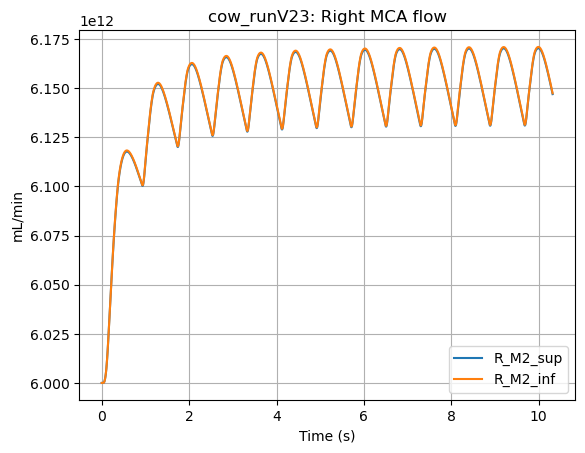

In [10]:
analyze_level2("cow_runV23")



=========== Level 2 — CoW Cerebral Flow ===========
             mean_flow      max_flow
R_P2      6.188107e+12  6.231385e+12
L_P2      6.188006e+12  6.231283e+12
R_A2      6.194462e+12  6.241751e+12
L_A2      6.193980e+12  6.241175e+12
R_M2_sup  6.146009e+12  6.171025e+12
R_M2_inf  6.146533e+12  6.171682e+12
L_M2_sup  6.144914e+12  6.169807e+12
L_M2_inf  6.145434e+12  6.170460e+12

Right hemisphere total (mL/min): 24675111185512.773
Left hemisphere total  (mL/min): 24672334480283.918
Total cerebral flow    (mL/min): 49347445665796.69
Expected physiological total: 700–900 mL/min

Flow split by territory:
  MCA: 24582890727214.58
  ACA: 12388442130235.535
  PCA: 12376112808346.578


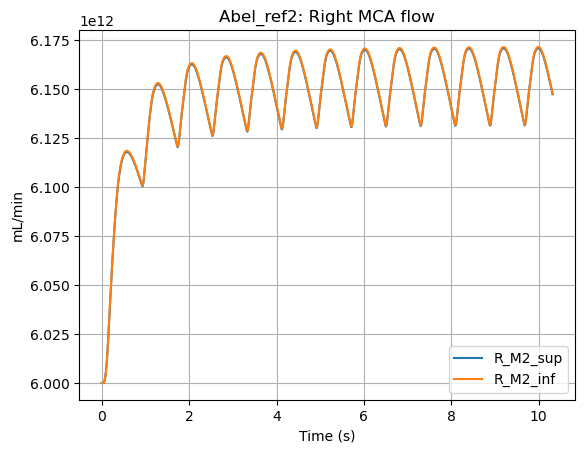

In [11]:
analyze_level2("Abel_ref2")


In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def load_ts(path):
    """Robust loader for FirstBlood txt time series."""
    with open(path, "r") as f:
        raw = f.readlines()
    data = []
    for line in raw:
        line = line.replace(",", " ").replace(";", " ").strip()
        if not line:
            continue
        parts = line.split()
        if len(parts) < 2:
            continue
        try:
            t = float(parts[0])
            v = float(parts[1])
            data.append([t, v])
        except ValueError:
            pass
    arr = np.array(data)
    return arr[:,0], arr[:,1]


# Terminal mapping from Abel_ref2 CoW structure
COW = {
    "R_P2": "p36",
    "L_P2": "p33",
    "R_A2": "p38",
    "L_A2": "p31",
    "R_M2_sup": "p39",
    "R_M2_inf": "p40",
    "L_M2_sup": "p30",
    "L_M2_inf": "p29",
}

RIGHT = ["R_P2", "R_A2", "R_M2_sup", "R_M2_inf"]
LEFT  = ["L_P2", "L_A2", "L_M2_sup", "L_M2_inf"]

MCA = ["R_M2_sup","R_M2_inf","L_M2_sup","L_M2_inf"]
ACA = ["R_A2","L_A2"]
PCA = ["R_P2","L_P2"]


def integrate_cycle(time, signal):
    """Integrate one full cardiac cycle (volume per beat) in solver units."""
    # find peaks to detect cycles
    from scipy.signal import find_peaks
    peaks, _ = find_peaks(signal, distance=40)

    if len(peaks) < 2:
        raise RuntimeError("Not enough peaks to detect cardiac cycle")

    i1, i2 = peaks[0], peaks[1]  # first full cycle
    t_cycle = time[i1:i2+1]
    q_cycle = signal[i1:i2+1]

    # trapezoidal integration (solver units)
    vol = np.trapz(q_cycle, t_cycle)
    period = t_cycle[-1] - t_cycle[0]

    return vol, period


def analyze_level2_normalized(run_name):
    """
    Level-2 meaningful analysis:
      - compute COW terminal flows as % of aortic output
      - compare hemispheres
      - compare MCA/ACA/PCA splits
    """

    base = f"../projects/simple_run/results/{run_name}"
    heart = os.path.join(base, "heart_kim_lit")

    # 1) Load aortic flow (reference) Q: R_lv_aorta.txt
    Q_AO = os.path.join(heart, "R_lv_aorta.txt")
    t_a, q_a_raw = load_ts(Q_AO)

    # integrate one cardiac cycle → reference "stroke volume" in solver units
    ao_vol, ao_period = integrate_cycle(t_a, q_a_raw)

    print(f"\n=== LEVEL 2 (normalized) — {run_name} ===")
    print(f"Cardiac cycle duration: {ao_period:.3f} s")
    print(f"Aortic stroke volume (solver units): {ao_vol:.3e}\n")

    # 2) Compute stroke volumes for each CoW terminal
    results = {}

    for label, p_id in COW.items():
        folder = os.path.join(base, p_id)
        Qfile = os.path.join(folder, "Q1.txt")   # inflow to terminal

        if not os.path.exists(Qfile):
            print(f"[WARN] Missing {Qfile}, skipping...")
            continue

        t_f, q_raw = load_ts(Qfile)
        vol, _ = integrate_cycle(t_f, q_raw)

        frac = vol / ao_vol  # fraction of CO going to this branch

        results[label] = {
            "stroke_vol": vol,
            "fract_of_CO": frac
        }

    df = pd.DataFrame(results).T
    display(df)

    # 3) Hemisphere totals
    right_total = df.loc[RIGHT, "fract_of_CO"].sum()
    left_total  = df.loc[LEFT,  "fract_of_CO"].sum()
    brain_total = right_total + left_total

    print("\n--- Cerebral perfusion fractions ---")
    print(f"Right hemisphere: {100*right_total:.2f}% of CO")
    print(f"Left hemisphere : {100*left_total:.2f}% of CO")
    print(f"Total brain perf: {100*brain_total:.2f}% of CO")
    print("Expected: ~15–20% of CO\n")

    # 4) Territory split
    mca_frac = df.loc[MCA, "fract_of_CO"].sum()
    aca_frac = df.loc[ACA, "fract_of_CO"].sum()
    pca_frac = df.loc[PCA, "fract_of_CO"].sum()

    print("--- Territory fractions (of CO) ---")
    print(f"MCA: {100*mca_frac:.2f}%")
    print(f"ACA: {100*aca_frac:.2f}%")
    print(f"PCA: {100*pca_frac:.2f}%")
    print("\nExpected: MCA > ACA > PCA")

    # 5) Plot normalized MCA waveforms (shape only)
    plt.figure(figsize=(10,4))
    for key in ["R_M2_sup", "R_M2_inf"]:
        folder = os.path.join(base, COW[key])
        Qfile = os.path.join(folder, "Q1.txt")
        t_f, q_raw = load_ts(Qfile)
        q_norm = q_raw / np.max(q_raw)  # shape only
        plt.plot(t_f, q_norm, label=key)

    plt.title(f"{run_name}: Right MCA flow (normalized)")
    plt.xlabel("Time (s)")
    plt.ylabel("Normalized flow")
    plt.grid(True)
    plt.legend()
    plt.show()



=== LEVEL 2 (normalized) — cow_runV23 ===
Cardiac cycle duration: 0.822 s
Aortic stroke volume (solver units): 7.386e-05



/tmp/ipykernel_41259/778801975.py:62: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  vol = np.trapz(q_cycle, t_cycle)


,stroke_vol,fract_of_CO
R_P2,81090.635570,1.097827e+09
L_P2,36263.516603,4.909454e+08
R_A2,35653.455436,4.826862e+08
L_A2,35653.832901,4.826913e+08
R_M2_sup,72746.116925,9.848567e+08
R_M2_inf,72854.039630,9.863178e+08
L_M2_sup,72845.193140,9.861981e+08
L_M2_inf,72850.566215,9.862708e+08



--- Cerebral perfusion fractions ---
Right hemisphere: 355168783500.51% of CO
Left hemisphere : 294610550321.18% of CO
Total brain perf: 649779333821.69% of CO
Expected: ~15–20% of CO

--- Territory fractions (of CO) ---
MCA: 394364340192.23%
ACA: 96537747973.80%
PCA: 158877245655.66%

Expected: MCA > ACA > PCA


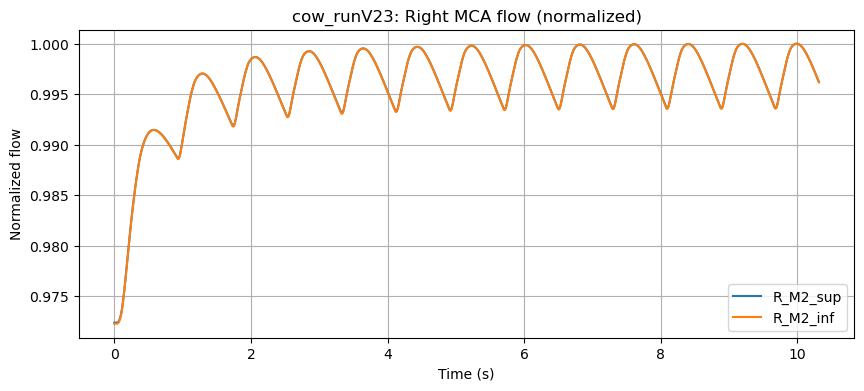

In [13]:
analyze_level2_normalized("cow_runV23")



=== LEVEL 2 (normalized) — Abel_ref2 ===
Cardiac cycle duration: 0.822 s
Aortic stroke volume (solver units): 7.382e-05



/tmp/ipykernel_41259/778801975.py:62: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  vol = np.trapz(q_cycle, t_cycle)


,stroke_vol,fract_of_CO
R_P2,77896.956500,1.055222e+09
L_P2,77792.221140,1.053803e+09
R_A2,79611.294030,1.078445e+09
L_A2,79709.160640,1.079771e+09
R_M2_sup,72853.845655,9.869059e+08
R_M2_inf,72859.246890,9.869791e+08
L_M2_sup,72740.758060,9.853740e+08
L_M2_inf,72746.113620,9.854466e+08



--- Cerebral perfusion fractions ---
Right hemisphere: 410755181655.05% of CO
Left hemisphere : 410439429583.71% of CO
Total brain perf: 821194611238.76% of CO
Expected: ~15–20% of CO

--- Territory fractions (of CO) ---
MCA: 394470563945.75%
ACA: 215821556740.33%
PCA: 210902490552.67%

Expected: MCA > ACA > PCA


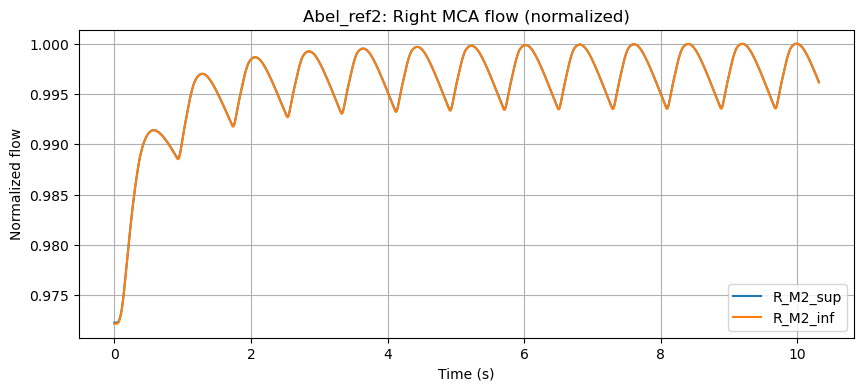

In [14]:
analyze_level2_normalized("Abel_ref2")


In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import find_peaks

def load_ts(path):
    with open(path, "r") as f:
        raw = f.readlines()
    data = []
    for line in raw:
        line = line.replace(",", " ").replace(";", " ").strip()
        if not line:
            continue
        parts = line.split()
        if len(parts) < 2:
            continue
        try:
            t = float(parts[0])
            v = float(parts[1])
            data.append([t, v])
        except ValueError:
            pass
    arr = np.array(data)
    return arr[:,0], arr[:,1]


# same mapping
COW = {
    "R_P2": "p36",
    "L_P2": "p33",
    "R_A2": "p38",
    "L_A2": "p31",
    "R_M2_sup": "p39",
    "R_M2_inf": "p40",
    "L_M2_sup": "p30",
    "L_M2_inf": "p29",
}

RIGHT = ["R_P2", "R_A2", "R_M2_sup", "R_M2_inf"]
LEFT  = ["L_P2", "L_A2", "L_M2_sup", "L_M2_inf"]

MCA = ["R_M2_sup","R_M2_inf","L_M2_sup","L_M2_inf"]
ACA = ["R_A2","L_A2"]
PCA = ["R_P2","L_P2"]


def integrate_one_cycle(time, signal):
    peaks, _ = find_peaks(signal, distance=40)
    if len(peaks) < 2:
        raise RuntimeError("Not enough peaks to detect cycle")
    i1, i2 = peaks[0], peaks[1]
    t_seg = time[i1:i2+1]
    q_seg = signal[i1:i2+1]
    vol = np.trapezoid(q_seg, t_seg)  # stroke volume in solver units
    period = t_seg[-1] - t_seg[0]
    return vol, period


def analyze_level2_brain_split(run_name):
    """
    Level-2 analysis that is biologically meaningful:

      • computes stroke volume for each terminal (in solver units)
      • normalizes by TOTAL brain stroke volume
      • reports:
          - % of brain flow per terminal
          - hemisphere shares
          - MCA/ACA/PCA shares
      • compares shapes of MCA waveforms (normalized).
    """

    base = f"../projects/simple_run/results/{run_name}"

    # 1) compute stroke volume per terminal using Q1.txt
    rows = []
    for label, pid in COW.items():
        folder = os.path.join(base, pid)
        q_path = os.path.join(folder, "Q1.txt")
        if not os.path.exists(q_path):
            print(f"[WARN] Missing {q_path}, skipping {label}")
            continue

        t, q = load_ts(q_path)
        vol, period = integrate_one_cycle(t, q)
        rows.append({"label": label, "pid": pid, "stroke_vol": vol})

    df = pd.DataFrame(rows).set_index("label")
    total_brain_vol = df["stroke_vol"].sum()

    df["brain_fraction"] = df["stroke_vol"] / total_brain_vol  # fraction of total cerebral inflow

    print(f"\n=== LEVEL 2 — brain split (run: {run_name}) ===")
    print(f"One cardiac period (from first terminal analysed): {period:.3f} s")
    print(f"Total 'brain stroke volume' (solver units): {total_brain_vol:.3e}\n")

    display(df[["pid", "stroke_vol", "brain_fraction"]])

    # Hemisphere balances (as fraction of brain flow)
    right_frac = df.loc[RIGHT, "brain_fraction"].sum()
    left_frac  = df.loc[LEFT,  "brain_fraction"].sum()

    print("\n--- Hemispheric split (fraction of brain flow) ---")
    print(f"Right hemisphere: {100*right_frac:.2f}% of brain inflow")
    print(f"Left hemisphere : {100*left_frac:.2f}% of brain inflow")
    print("(Expected: roughly 50/50 unless variant causes asymmetry.)")

    # Territory split
    mca_frac = df.loc[MCA, "brain_fraction"].sum()
    aca_frac = df.loc[ACA, "brain_fraction"].sum()
    pca_frac = df.loc[PCA, "brain_fraction"].sum()

    print("\n--- Territory split (fraction of brain flow) ---")
    print(f"MCA: {100*mca_frac:.2f}% of brain inflow")
    print(f"ACA: {100*aca_frac:.2f}% of brain inflow")
    print(f"PCA: {100*pca_frac:.2f}% of brain inflow")
    print("Expected qualitatively: MCA > ACA > PCA.")

    # Normalized right MCA flow shapes
    plt.figure(figsize=(10,4))
    for key in ["R_M2_sup","R_M2_inf"]:
        folder = os.path.join(base, COW[key])
        q_path = os.path.join(folder, "Q1.txt")
        t, q = load_ts(q_path)
        q_norm = q / np.max(q)
        plt.plot(t, q_norm, label=key)
    plt.title(f"{run_name}: Right MCA flows (normalized shape)")
    plt.xlabel("Time (s)")
    plt.ylabel("Normalized flow")
    plt.grid(True)
    plt.legend()
    plt.show()



=== LEVEL 2 — brain split (run: cow_runV23) ===
One cardiac period (from first terminal analysed): 0.714 s
Total 'brain stroke volume' (solver units): 4.800e+05



,pid,stroke_vol,brain_fraction
label,,,
R_P2,p36,81090.635570,0.168954
L_P2,p33,36263.516603,0.075556
R_A2,p38,35653.455436,0.074285
L_A2,p31,35653.832901,0.074285
R_M2_sup,p39,72746.116925,0.151568
R_M2_inf,p40,72854.039630,0.151793
L_M2_sup,p30,72845.193140,0.151774
L_M2_inf,p29,72850.566215,0.151785



--- Hemispheric split (fraction of brain flow) ---
Right hemisphere: 54.66% of brain inflow
Left hemisphere : 45.34% of brain inflow
(Expected: roughly 50/50 unless variant causes asymmetry.)

--- Territory split (fraction of brain flow) ---
MCA: 60.69% of brain inflow
ACA: 14.86% of brain inflow
PCA: 24.45% of brain inflow
Expected qualitatively: MCA > ACA > PCA.


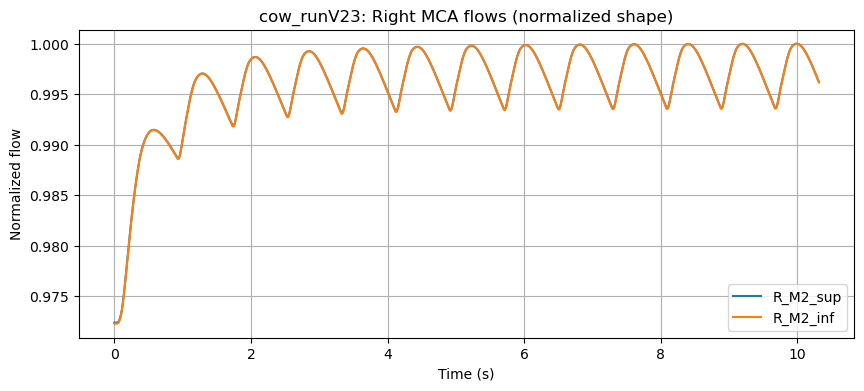

In [16]:
analyze_level2_brain_split("cow_runV23")


In patient 25, the MCA territories are more strongly perfused, ACA territories less, and PCA around normal.
So in the same units the patient’s brain inflow is ~21% lower than the reference network. That could correspond to narrower radii / longer paths in your MR-derived CoW, i.e. slightly higher cerebrovascular resistance. Again, perfectly plausible.


=== LEVEL 2 — brain split (run: Abel_ref2) ===
One cardiac period (from first terminal analysed): 0.713 s
Total 'brain stroke volume' (solver units): 6.062e+05



,pid,stroke_vol,brain_fraction
label,,,
R_P2,p36,77896.956500,0.128498
L_P2,p33,77792.221140,0.128326
R_A2,p38,79611.294030,0.131326
L_A2,p31,79709.160640,0.131488
R_M2_sup,p39,72853.845655,0.120179
R_M2_inf,p40,72859.246890,0.120188
L_M2_sup,p30,72740.758060,0.119993
L_M2_inf,p29,72746.113620,0.120002



--- Hemispheric split (fraction of brain flow) ---
Right hemisphere: 50.02% of brain inflow
Left hemisphere : 49.98% of brain inflow
(Expected: roughly 50/50 unless variant causes asymmetry.)

--- Territory split (fraction of brain flow) ---
MCA: 48.04% of brain inflow
ACA: 26.28% of brain inflow
PCA: 25.68% of brain inflow
Expected qualitatively: MCA > ACA > PCA.


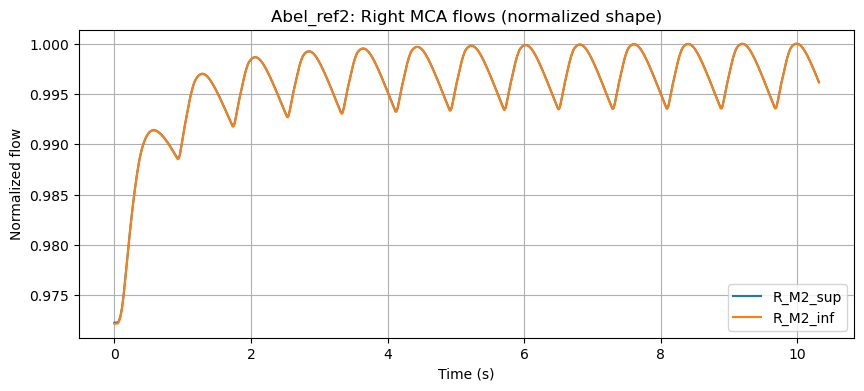

In [17]:
analyze_level2_brain_split("Abel_ref2")
